In [15]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import random
from itertools import chain
random_state=42

In [2]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=random_state, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=random_state, remove=('headers', 'footers', 'quotes'))

[]

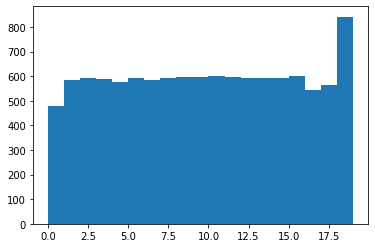

In [3]:
plt.hist(twenty_train.target, bins=np.arange(20))
plt.plot()

In [4]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)

tf_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)

In [5]:
svd = TruncatedSVD(n_components=128, n_iter=5, random_state=random_state, algorithm="randomized")
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_train_lsa = normalize(X_train_lsa, norm='l2', axis=1)



In [6]:
# random documents of each news group
def sample_each(index_target, sample_id, nb_to_select=1):    
    return list(chain.from_iterable([filter_select(index_target, i, nb_to_select) for i in sample_id]))

def filter_select(index_target, by, nb_to_select=1):
    filtered = tuple(filter(lambda i_t : i_t[1]==by, index_target))
    return random.choices(filtered, k=nb_to_select)

index_target = list(enumerate(twenty_train.target))
indexes = list(map(lambda p : p[0], sample_each(index_target, list(range(20)))))
lsa_to_test = zip(indexes,X_train_lsa[indexes])

In [7]:
#for test in lsa_to_test:
def nearest(corpus, lsa, to_test):
    close_index = sorted(range(len(lsa)), key=lambda i : 1 - np.dot(to_test,lsa[i])/np.linalg.norm(to_test)*np.linalg.norm(lsa[i]))    
    return close_index, [corpus[i] for i in close_index]


corpus = list()
indexes = list()
target = list()
for indexes_to_test, to_test in lsa_to_test:
    target.append(twenty_train.data[indexes_to_test])
    indexes_sorted_by_cosine, corpus_sorted_by_cosine = nearest(twenty_train.data, X_train_lsa, to_test)
    indexes_sorted_by_cosine.append(indexes_sorted_by_cosine)
    corpus.append(corpus_sorted_by_cosine)

In [9]:
print("Target:________________________")
print(target[0],'\n')

print("Predicted:_____________________")
print(corpus[0][:1][0])


Target:________________________

: >EVER HEAR OF
: >BAPTISM AT BIRTH?  If that isn't preying on the young, I don't know what
: >is...
: >
: RB>   
: RB>   No, that's praying on the young.  Preying on the young comes
: RB>   later, when the bright eyed little altar boy finds out what the
: RB>   priest really wears under that chasible.

Does this statement further the atheist cause in some way, surely it's
not intended as wit ... 

Predicted:_____________________

: >EVER HEAR OF
: >BAPTISM AT BIRTH?  If that isn't preying on the young, I don't know what
: >is...
: >
: RB>   
: RB>   No, that's praying on the young.  Preying on the young comes
: RB>   later, when the bright eyed little altar boy finds out what the
: RB>   priest really wears under that chasible.

Does this statement further the atheist cause in some way, surely it's
not intended as wit ...


In [10]:
print(X_train_lsa.shape)

(11314, 128)


In [65]:
tranche_size = 8
nb_tranche = len(X_train_lsa[0])//tranche_size
X_train_lsa_q = X_train_lsa.reshape(-1,nb_tranche,tranche_size)
n_clusters=4
kmeans_list = list()
all_labels = list()


for i in range(16):
    test = X_train_lsa_q[:,i:i+1].reshape(-1,tranche_size)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(test)
    kmeans_list.append(kmeans)
    labels = kmeans.labels_
    all_labels.append(labels)

all_labels = np.vstack(tuple(all_labels))

"""
Memoire non compréssé : nb_exemple * nb_coeff_lsa (float-8byte) = 11314 * 128 * 8 = 11585536
Memoire compréssé : nb_exemple * label_index (unsigned int / 4-byte) 
                    + nb_centroïde * taille_tranche * nb_tranche
                    +  
"""


